In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score
    , confusion_matrix, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [3]:
# Custom tokenizer using SpaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

In [4]:
# Load the dataset from Hugging Face:
df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

df.shape
df.head()
df.info()

(24783, 6)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [6]:
# Encode labels (spam: 1, ham: 0)

# 0: 'hate-speech', 1: 'offensive-language' or 2: 'neither'

df['label_actual'] = df['class'].map({0: 'hate-speech', 1: 'offensive-language', 2: 'neither' })

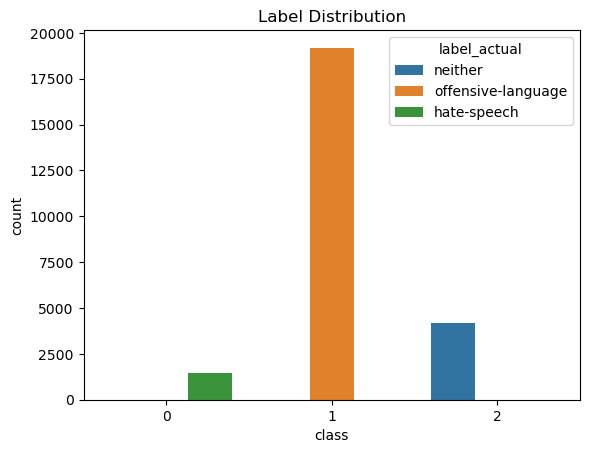

In [7]:
# Visualize label distribution
sns.countplot(
    x='class', data=df, hue='label_actual'
)
plt.title("Label Distribution")
plt.show();

In [8]:
df.head(1)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,label_actual
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither


In [9]:
X = df['tweet']
y = df['class']

X.shape, y.shape

((24783,), (24783,))

In [11]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19826,), (4957,), (19826,), (4957,))

In [39]:
# Vectorize text data using TfidfVectorizer (* with spaCy_tokenizer;)
tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenizer, lowercase=True
    , stop_words='english' # adding in the english stopwords w/ spaCy tokenizer; might break the model,,,
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [40]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((19826, 31621), (4957, 31621))

<19826x31621 sparse matrix of type '<class 'numpy.float64'>'
	with 153608 stored elements in Compressed Sparse Row format>

In [41]:
# Select a base model (e.g., MultinomialNB) for hyperparameter tuning
base_model = MultinomialNB()

In [42]:
# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    base_model
    , param_grid
    , cv=5
    , scoring='accuracy'
)

In [43]:
grid_search.fit(X_train_tfidf, y_train)

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.1, 0.5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


In [44]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'alpha': 0.1}
Best Cross-Validation Accuracy: 0.8416726157203825


In [45]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

# Now FIT the best_model (MUST DO BEFORE PREDICTING!!! {otherwise, you essentially reset the model! :o })
best_model.fit(X_train_tfidf, y_train)

,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None


In [46]:
y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.8327617510591083


array([[  12,  258,   16],
       [  16, 3774,   48],
       [   2,  489,  342]])

              precision    recall  f1-score   support

           0       0.40      0.04      0.08       286
           1       0.83      0.98      0.90      3838
           2       0.84      0.41      0.55       833

    accuracy                           0.83      4957
   macro avg       0.69      0.48      0.51      4957
weighted avg       0.81      0.83      0.80      4957



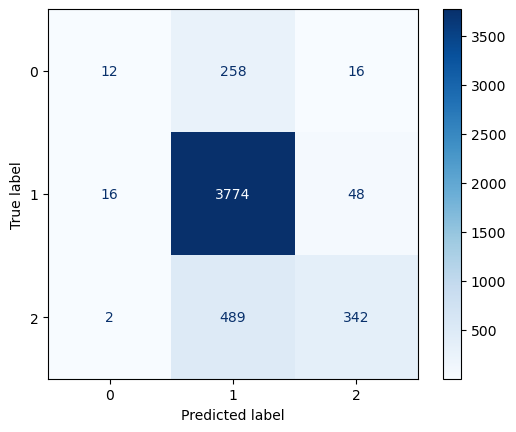

In [47]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test
    , cmap='Blues'
);

In [48]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=spacy_tokenizer
        , lowercase=True
        , stop_words='english'
    ))
    , ('model', best_model)
])

In [49]:
# HAVE TO FIT THE PIPES!!!
# Since the model is already trained, can fit directly to X, y;

pipeline.fit(X, y)

,steps,"[('tfidf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...t 0x1777880e0>


In [50]:
df.head(1)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,label_actual
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither


In [51]:
# Test pipeline on sample strings
sample_strings = [
    "You suck and I hate your stupid face!",
    "HFuckity fuck fucker fuckeroni",
    "Yo my dude foshizzlecoin is off the sheezy mothafucka",
    "Bitcoin is going to the moooooooon!",
    "Enlarge your portfolio 1000% with my proven investment secrets!",
    "@bizzle, whassup muh thugg",
    "This airline sucks!",
    "The thugg-lyfe chose ME"
]

In [52]:
predictions = pipeline.predict(sample_strings)

# Display predictions mapping
label_mapping = {0: 'hate-speech', 1: 'offensive-language', 2: 'neither'}

for text, label in zip(sample_strings, predictions):
    # Use the label to get the corresponding prediction
    prediction_text = label_mapping.get(label, 'unknown')
    print(f"Message: {text} -> Prediction: {prediction_text}\n")

Message: You suck and I hate your stupid face! -> Prediction: offensive-language

Message: HFuckity fuck fucker fuckeroni -> Prediction: offensive-language

Message: Yo my dude foshizzlecoin is off the sheezy mothafucka -> Prediction: offensive-language

Message: Bitcoin is going to the moooooooon! -> Prediction: offensive-language

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: offensive-language

Message: @bizzle, whassup muh thugg -> Prediction: offensive-language

Message: This airline sucks! -> Prediction: neither

Message: The thugg-lyfe chose ME -> Prediction: neither



In [53]:
X_test_tfidf.shape

(4957, 31621)

In [31]:
base_model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [32]:
best_model

,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None
